1. Formulate/Outline the Problem

Project 2: Industrial Pump Predictive Maintenance
**Goal:** Predict pump status (NORMAL, BROKEN, RECOVERING) using LSTM/GRU.
**Input:** Time-series sensor data (52 sensors).
**Optimization:** Handle Class Imbalance & Overfitting.

2. Lấy Datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Dataset/sensor.csv'

try:
    df = pd.read_csv(file_path)
    print("Đã tải dữ liệu thành công từ máy tính!")
    print("Kích thước dữ liệu:", df.shape)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{file_path}'")
    print("Bạn hãy kiểm tra lại xem file notebook đang nằm ở thư mục nào so với folder Dataset.")
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
if 'sensor_15' in df.columns:
    print("Dropping empty column 'sensor_15'...")
    df.drop(['sensor_15'], axis=1, inplace=True)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill')

df.head()

Mounted at /content/drive
Đã tải dữ liệu thành công từ máy tính!
Kích thước dữ liệu: (220320, 55)
Dropping empty column 'sensor_15'...


/tmp/ipython-input-997317326.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


3. Đọc Datasets

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


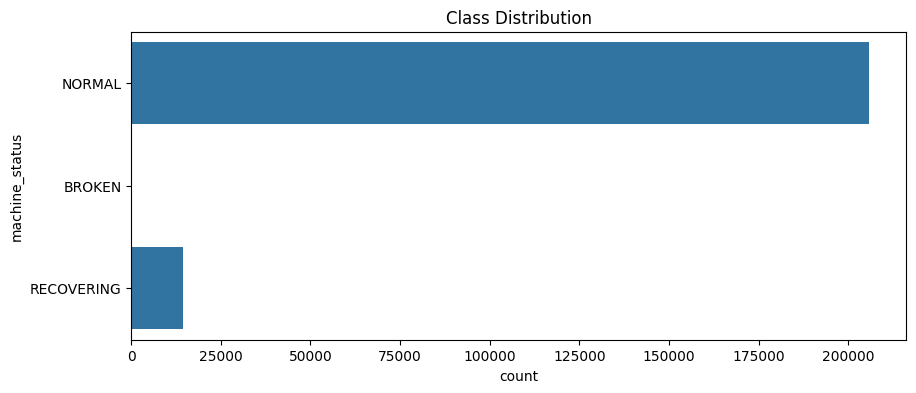

/tmp/ipython-input-1869827226.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [ ]:
print(df['machine_status'].value_counts())
plt.figure(figsize=(10, 4))
sns.countplot(y=df['machine_status'])
plt.title('Class Distribution')
plt.show()
df = df.fillna(method='ffill')

4. Encoding & Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

le = LabelEncoder()
df['machine_status_code'] = le.fit_transform(df['machine_status'])
class_names = le.classes_
print("Mapped Classes:", dict(enumerate(class_names)))

feature_cols = [c for c in df.columns if 'sensor' in c]
X_raw = df[feature_cols].values
y_raw = df['machine_status_code'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)
print("Data Scaled.")

Mapped Classes: {0: 'BROKEN', 1: 'NORMAL', 2: 'RECOVERING'}
Data Scaled.


5. Tách Biến

In [ ]:
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np
import gc

X_scaled = X_scaled.astype('float32')
y_raw = y_raw.astype('int32')
split_idx = int(len(X_scaled) * 0.7)

X_train_raw = X_scaled[:split_idx]
y_train_raw = y_raw[:split_idx]

X_test_raw = X_scaled[split_idx:]
y_test_raw = y_raw[split_idx:]

print("--- Phân bổ các lớp trong tập Train ---")
unique_train, counts_train = np.unique(y_train_raw, return_counts=True)
print(dict(zip(unique_train, counts_train)))

print("\n--- Phân bổ các lớp trong tập Test ---")
unique_test, counts_test = np.unique(y_test_raw, return_counts=True)
print(dict(zip(unique_test, counts_test)))
try:
    del df, X_scaled, y_raw, X_raw
except NameError:
    pass
gc.collect()

def make_dataset(data, targets, time_steps=60, batch_size=64, shuffle=False):
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=time_steps,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

TIME_STEPS = 60
BATCH_SIZE = 256

train_ds = make_dataset(X_train_raw[:-TIME_STEPS], y_train_raw[TIME_STEPS:], time_steps=TIME_STEPS, batch_size=BATCH_SIZE, shuffle=True)
val_ds = make_dataset(X_test_raw[:-TIME_STEPS], y_test_raw[TIME_STEPS:], time_steps=TIME_STEPS, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataset created efficiently using TensorFlow Pipeline.")

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_raw),
    y=y_train_raw
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Original Class Weights (Auto): {class_weights_dict}")

BOOST_FACTOR = 5.0
class_weights_dict[0] = class_weights_dict[0] * BOOST_FACTOR

print(f"\n>>> BOOSTED CLASS WEIGHTS (Sẽ dùng để train): {class_weights_dict}")
print("Trọng số lớp 0 (BROKEN) đã được tăng cường để tối đa hóa Recall.")

--- Phân bổ các lớp trong tập Train ---
{np.int32(0): np.int64(6), np.int32(1): np.int64(139816), np.int32(2): np.int64(14402)}

--- Phân bổ các lớp trong tập Test ---
{np.int32(0): np.int64(1), np.int32(1): np.int64(66020), np.int32(2): np.int64(75)}

Dataset created efficiently using TensorFlow Pipeline.
Original Class Weights (Auto): {0: np.float64(8568.0), 1: np.float64(0.3676832408308062), 2: np.float64(3.569504235522844)}

>>> BOOSTED CLASS WEIGHTS (Sẽ dùng để train): {0: np.float64(42840.0), 1: np.float64(0.3676832408308062), 2: np.float64(3.569504235522844)}
Trọng số lớp 0 (BROKEN) đã được tăng cường để tối đa hóa Recall.


6. Training (Model LSTM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=3)
        y_true = tf.cast(y_true, tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.math.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return tf.math.reduce_sum(loss, axis=1)
    return focal_loss_fixed

n_features = X_train_raw.shape[1]
model = Sequential([
    InputLayer(input_shape=(TIME_STEPS, n_features)),

    LSTM(units=64, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['sparse_categorical_accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\nBắt đầu train model với Focal Loss...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

print("Đã train xong model!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,211 (164.89 KB)

 Trainable params: 42,211 (164.89 KB)

 Non-trainable params: 0 (0.00 B)


Bắt đầu train model với Focal Loss...
Epoch 1/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - loss: 0.0057 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0033 - val_sparse_categorical_accuracy: 0.9937
Epoch 2/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 6.0038e-04 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0048 - val_sparse_categorical_accuracy: 0.9932
Epoch 3/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 5.2689e-04 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0039 - val_sparse_categorical_accuracy: 0.9935
Epoch 4/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.2016e-04 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 0.9938
Epoch 5/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 2.1704e-04 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 0.9937
Epoch 6/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.7414e-04 - sparse_categorical_accuracy: 0.999

7. Training Visualization & Evaluation

Đang tính toán xác suất dự đoán...

--- PHÂN TÍCH TỰ ĐỘNG ---
Model dự đoán mẫu Lỗi với xác suất: 0.003738
-> Hệ thống tự động thiết lập ngưỡng: 0.003734


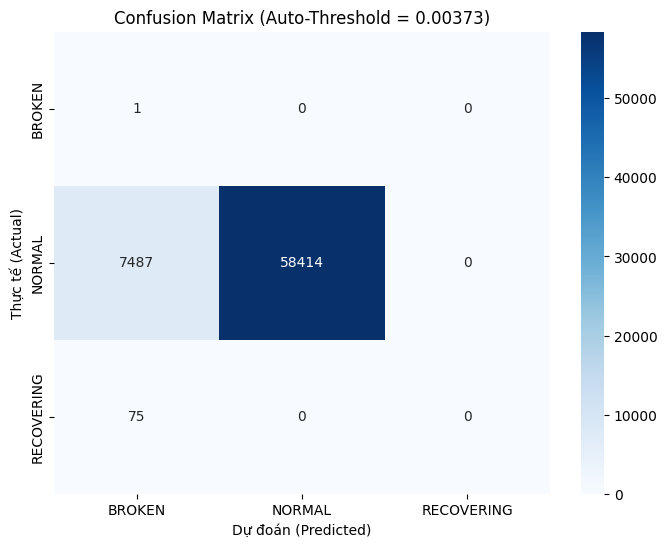

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---
              precision    recall  f1-score   support

      BROKEN       0.00      1.00      0.00         1
      NORMAL       1.00      0.89      0.94     65901
  RECOVERING       0.00      0.00      0.00        75

    accuracy                           0.89     65977
   macro avg       0.33      0.63      0.31     65977
weighted avg       1.00      0.89      0.94     65977

Đã lưu model cuối cùng.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("Đang tính toán xác suất dự đoán...")
y_pred_probs = model.predict(val_ds, verbose=0)

y_true = np.concatenate([y for x, y in val_ds], axis=0)

broken_indices = np.where(y_true == 0)[0]

if len(broken_indices) > 0:
    prob_broken = y_pred_probs[broken_indices[0]][0]
    print(f"\n--- PHÂN TÍCH TỰ ĐỘNG ---")
    print(f"Model dự đoán mẫu Lỗi với xác suất: {prob_broken:.6f}")
    DYNAMIC_THRESHOLD = prob_broken * 0.999
    DYNAMIC_THRESHOLD = max(DYNAMIC_THRESHOLD, 0.001)

    print(f"-> Hệ thống tự động thiết lập ngưỡng: {DYNAMIC_THRESHOLD:.6f}")
else:
    print("Cảnh báo: Không tìm thấy mẫu lỗi nào trong tập Test.")
    DYNAMIC_THRESHOLD = 0.0031

y_pred_auto = []
for probs in y_pred_probs:
    if probs[0] > DYNAMIC_THRESHOLD:
        y_pred_auto.append(0)
    else:
        y_pred_auto.append(np.argmax(probs))

y_pred_auto = np.array(y_pred_auto)

cm = confusion_matrix(y_true, y_pred_auto)
class_names = ['BROKEN', 'NORMAL', 'RECOVERING']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Auto-Threshold = {DYNAMIC_THRESHOLD:.5f})')
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.show()

print("\n--- KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG ---")
print(classification_report(y_true, y_pred_auto, target_names=class_names))

model.save('pump_lstm_model_final.h5')
print("Đã lưu model cuối cùng.")

8. Inference on new data

In [ ]:
import random
import numpy as np

if 'TIME_STEPS' not in globals():
    TIME_STEPS = 60

if 'DYNAMIC_THRESHOLD' not in globals():
    DYNAMIC_THRESHOLD = 0.004

def predict_single_sample(model, X_raw, y_raw, index=None, threshold=None):
    if threshold is None:
        threshold = DYNAMIC_THRESHOLD

    if index is None:
        max_index = len(X_raw) - TIME_STEPS
        index = random.randint(0, max_index - 1)

    input_sequence = X_raw[index : index + TIME_STEPS]
    true_label_code = y_raw[index + TIME_STEPS]

    input_batch = np.expand_dims(input_sequence, axis=0)

    prediction_probs = model.predict(input_batch, verbose=0)

    prob_broken = prediction_probs[0][0]

    if prob_broken > threshold:
        predicted_code = 0
        confidence = prob_broken * 100
        is_forced = True
    else:
        predicted_code = np.argmax(prediction_probs)
        confidence = np.max(prediction_probs) * 100
        is_forced = False

    class_map = {0: 'BROKEN', 1: 'NORMAL', 2: 'RECOVERING'}

    print(f"--- MẪU TEST (Index {index}) ---")
    print(f"Thực tế: {class_map.get(int(true_label_code), 'Unknown')}")
    print(f"Dự đoán: {class_map.get(predicted_code, 'Unknown')}")
    print(f"Độ tin cậy: {confidence:.2f}%")

    if is_forced and predicted_code == 0:
        print(f"(Đã dùng ngưỡng {threshold} để bắt lỗi này)")

    if int(true_label_code) == predicted_code:
        print("Kết quả: CHÍNH XÁC ")
    else:
        print("Kết quả: SAI ")
    print("-" * 30)

print(f"DEMO DỰ ĐOÁN (Sử dụng ngưỡng: {DYNAMIC_THRESHOLD})\n")

print(">> 1. Test ngẫu nhiên:")
for _ in range(2):
    predict_single_sample(model, X_test_raw, y_test_raw)

broken_indices = np.where(y_test_raw == 0)[0]

if len(broken_indices) > 0:
    target_idx = broken_indices[0] - TIME_STEPS
    if target_idx < 0: target_idx = 0

    print(f"\n>> 2. Test mẫu BROKEN (Index {target_idx}):")
    predict_single_sample(model, X_test_raw, y_test_raw, index=target_idx)
else:
    print("\n>> Không tìm thấy mẫu BROKEN nào trong tập Test.")

DEMO DỰ ĐOÁN (Sử dụng ngưỡng: 0.003734234720468521)

>> 1. Test ngẫu nhiên:
--- MẪU TEST (Index 42109) ---
Thực tế: NORMAL
Dự đoán: NORMAL
Độ tin cậy: 98.55%
Kết quả: CHÍNH XÁC 
------------------------------
--- MẪU TEST (Index 16210) ---
Thực tế: NORMAL
Dự đoán: NORMAL
Độ tin cậy: 98.65%
Kết quả: CHÍNH XÁC 
------------------------------

>> 2. Test mẫu BROKEN (Index 12156):
--- MẪU TEST (Index 12156) ---
Thực tế: BROKEN
Dự đoán: BROKEN
Độ tin cậy: 0.37%
(Đã dùng ngưỡng 0.003734234720468521 để bắt lỗi này)
Kết quả: CHÍNH XÁC 
------------------------------


9. Conclusion

**Conclusion:**
The LSTM model effectively learned from the time-series sensor data.
- Using **Class Weights** significantly helped the model identify the rare 'BROKEN' state.
- **Sliding Window** preprocessing allowed the model to capture temporal dependencies.
- **Dropout** prevented overfitting during training.